#### iLQR for point mass example with obstacle in 3d

In [1]:
import sys

In [2]:
sys.path.append('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

## Steps:

#### 1. Define the dynamical system (e.g., double integrator, 2d robot, n-d manipulator, etc.)
#### 2. Define the cost functions
#### 3. Construct the ILQR problem
#### 4. Solve

#### Create point mass system with dimension 2 (double integrator)

In [4]:
dt = 0.05  #duration of 1 time step
T = 100    #total number of time steps
Dx, Du = 6, 3 #dimensions of x and u
dof = 3

#Define the matrix A and B to define a double integrator
A = np.eye(Dx)
A[:dof,dof:] = np.eye(dof)*dt
B = np.zeros((Dx, Du))
B[:dof,:] = 0.5*np.eye(Du)*(dt**2)
B[dof:, :] = np.eye(Du)*dt

sys = LinearSystem(A, B)

#### Set initial state and control trajectory

In [5]:
x0 = np.zeros(Dx)
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [6]:
Q = np.eye(sys.Dx)*0.00  #coefficient for running cost
Qf = np.eye(sys.Dx)*10  #coefficient for terminal cost
R = np.eye(sys.Du)*0.005  #control coefficient
mu = 1e-6              #regularization coefficient

#### Set reference target

In [7]:
x_target = np.array([2, 2, 2, 0,0, 0])

#### Set obstacle

In [57]:
p_obs1 = np.array([1.,1., 1.])   #obstacle position
r_obs1 = np.array([0.5, 0.2, 0.1]) #radius of the ellipse
ori_obs1 = 0  #rotate the ellipse clockwise
w_obs1 = 1   #weight of the obstacle cost

#compute the covariance matrix of the ellipse
#Sigma_obs1 = compute_covariance(r_obs1, ori_obs1)
Sigma_obs1 = np.eye(dof)*0.5


# #plot the ellipse
# fig, ax = plt.subplots()
# plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
# ax.set_xlim(0, 2)
# ax.set_ylim(0,2)
# ax.set_aspect('equal')

### iLQR using cost model

#### Define the cost

In [58]:
#The costs consist of: a) state tracking (Q), b) control regularization (R), c) obstacle cost
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []
for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_target)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)    
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningObstacleCost])
    costs += [runningCost]

terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_target)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalObstacleCost])

costs += [terminalCost]

#### Construct ILQR

In [62]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)    #set initial guess

#### Solve and Plot

In [63]:
n_iter = 100
ilqr_cost.solve(n_iter, method='recursive', cost_thres=1e-3)
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us


Cost converges at iteration 17, cannot decrease further


## Show in pybullet

In [26]:
import pybullet as p
import pybullet_data

In [27]:
p.connect(p.GUI)

0

In [32]:
p.resetSimulation()

In [43]:
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [45]:
p.loadURDF('plane.urdf')

2

In [33]:
_,_,obj_id = create_primitives(rgbaColor=[0,0,1,1],radius = 0.1)
_,_,obs_id = create_primitives(radius = 0.5)

In [34]:
p.resetBasePositionAndOrientation(obs_id, p_obs1, (0,0,0,1))

In [38]:
def plot_traj(xs, obj_id, dt = 0.01):
    for x in xs:
        p.resetBasePositionAndOrientation(obj_id, x[:3], (0,0,0,1))
        time.sleep(dt)

In [66]:

plot_traj(ilqr_cost.xs, obj_id)

(-0.10219167809896677,
 2.146025240078302,
 -0.09987546891876384,
 2.0973848472940406)

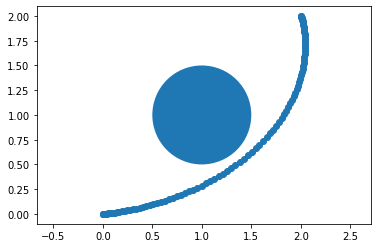

In [67]:
fig, ax = plt.subplots()
plt.plot(ilqr_cost.xs[:,0], ilqr_cost.xs[:,1], 'o')
c1 = plt.Circle(p_obs1[0:2],radius=0.5)
ax.add_patch(c1)
plt.axis('equal')